In [ ]:
!pip install haystack-ai
!pip install wikipedia
!pip install sentence-transformers

In [ ]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

In [ ]:
from haystack import component, Pipeline, Document
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.builders.prompt_builder import PromptBuilder
from typing import List

@component
class LLMMetadataExtractor:

    def __init__(self):
        metadata_extraction_prompt = """
        Given a Wikipedia article about a city, you extract the number of inhabitants or the estimated population
        living in that city. Usually, this information is found in the first sentence and can be an exact number or an estimate.
        Please always convert the number to an ordinal number.
        Don't include the word inhabitants, population, or any other word that refers to the number of people living in the city in the answer.
        If in the article there is no information about the number of inhabitants, please return None
        ### Example 1
        Wikipedia:
        '''
        Berlin (/bɜːrˈlɪn/, bur-LIN; German: [bɛʁˈliːn] ⓘ)[10] is the capital and largest city of Germany by both area
        and by population.[11] Its more than 3.85 million inhabitants[12] make it the European Union's most populous city,
        according to population within city limits.[4] Simultaneously, the city is one of the  States of Germany. Berlin
        is surrounded by the State of Brandenburg and Brandenburg's capital Potsdam is nearby. Berlin's urban area has
        a population of around 4.5 million and is therefore the most populous urban area in Germany.
        '''
        Inhabitants: 3.850.000
        ### Example 2:
        Wikipedia:
        '''
        {{document}}
        '''
        Inhabitants:
        """

        builder = PromptBuilder(metadata_extraction_prompt)
        llm = OpenAIGenerator(model="gpt-3.5-turbo")
        self.pipeline = Pipeline()
        self.pipeline.add_component(name="builder", instance=builder)
        self.pipeline.add_component(name="llm", instance=llm)
        self.pipeline.connect("builder", "llm")

    @component.output_types(documents=List[Document])
    def run(self, documents: List[Document]):
      docs_with_metadata = []
      for doc in documents:
        result = self.pipeline.run({'builder': {'document': doc.content}})
        doc.meta["inhabitants"] = result['llm']['replies'][0]
        docs_with_metadata.append(doc)
      return {"documents": docs_with_metadata}

In [ ]:
import wikipedia

metadata_extractor = LLMMetadataExtractor()
page = wikipedia.page(title='Lisbon', auto_suggest=False)
lisbon_wiki_text = page.content
lisbon_doc = Document(content=lisbon_wiki_text.split("\\n\\n")[0])
reply = metadata_extractor.run([lisbon_doc])
reply['documents']

[Document(id=dce21278cc3dd4c56852dc8f07004e004a37f94278ab788c325becdd1f06cdf8, content: 'Lisbon (; Portuguese: Lisboa [liʒˈβoɐ] ) is the capital and largest city of Portugal, with an estima...', meta: {'inhabitants': '548.703'})]

In [ ]:
documents = []
for title in ["Lisbon", "Hamburg", "Rome", "Madrid"]:
    page = wikipedia.page(title=title, auto_suggest=False)
    doc = Document(content=page.content.split("\n\n")[0])
    documents.append(doc)

metadata_extractor = LLMMetadataExtractor()
results = metadata_extractor.run(documents)
results['documents']

[Document(id=b9444672253f9d222df1bf69cce7675efe13858ab16f42c6d9c7d0ea37dfad2c, content: 'Lisbon (; Portuguese: Lisboa [liʒˈβoɐ] ) is the capital and largest city of Portugal, with an estima...', meta: {'inhabitants': '548.703'}),
 Document(id=c69854b7454e8c2fc5b753c5d8c2f95342a3b1b51053e0f9fe5c23fb9d6d3873, content: 'Hamburg (German: [ˈhambʊʁk] , locally also [ˈhambʊɪ̯ç] ; Low Saxon: Hamborg [ˈhambɔːç] ), officially...', meta: {'inhabitants': 'Inhabitants: 1.900.000'}),
 Document(id=a12fb9ffb2a4e65b4d83cf798efd67eda8a0c68b883555f4ad285cbaa3885b5e, content: 'Rome (Italian and Latin: Roma, Italian: [ˈroːma] ) is the capital city of Italy. It is also the capi...', meta: {'inhabitants': '3.850.000'}),
 Document(id=55a55cc869537a2487e063b93d7bcf70add641468565c7f1c2402686b24c08b1, content: 'Madrid ( mə-DRID, Spanish: [maˈðɾið] ) is the capital and most populous city of Spain. The city has ...', meta: {'inhabitants': '3.400.000'})]

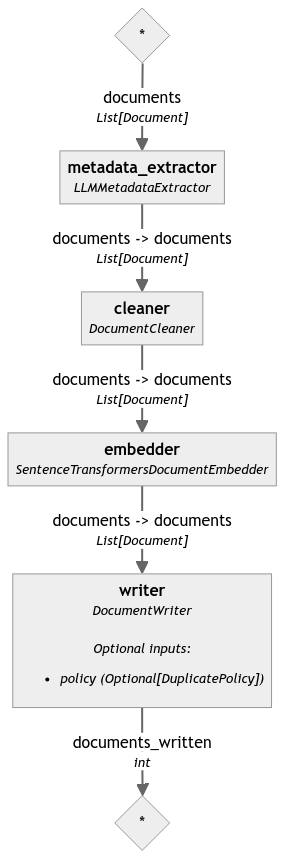

In [ ]:
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

metadata_extractor = LLMMetadataExtractor()

document_store = InMemoryDocumentStore()
document_cleaner = DocumentCleaner()
document_embedder = SentenceTransformersDocumentEmbedder(
    model="thenlper/gte-large",
    meta_fields_to_embed=['inhabitants']
)
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE)

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(name="metadata_extractor", instance=metadata_extractor)
indexing_pipeline.add_component(name="cleaner", instance=document_cleaner)
indexing_pipeline.add_component("embedder", document_embedder)
indexing_pipeline.add_component("writer", document_writer)
indexing_pipeline.connect("metadata_extractor", "cleaner")
indexing_pipeline.connect("cleaner", "embedder")
indexing_pipeline.connect("embedder", "writer")

In [ ]:
indexing_pipeline.run({"documents": documents})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'writer': {'documents_written': 4}}